<a href="https://colab.research.google.com/github/arun-arunisto/Tensorflow_Tutorial/blob/todo/Keras_Implement_Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Implementing a CNN in Tensorflow and Keras
CNN architecture similar to the VGG-16 but with fewer layers, here we are going to learn how to model this architecture and train it on a small dataset called CIFAR-10. and also introducing a new layer type called "dropout"
<img src="https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-cifar10-architecture.png">

In [1]:
#importing required packages
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [2]:
#fixing seed to make training deterministic
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

##CIFAR-10 Dataset
This dataset consists of 60,000 color images from 10 classes, with 6,000 images per class.
There are 50,000 images and 10,000 test images. Sample images with class names shown below
<img src="https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cifar10-classes.png">

In [3]:
#loading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


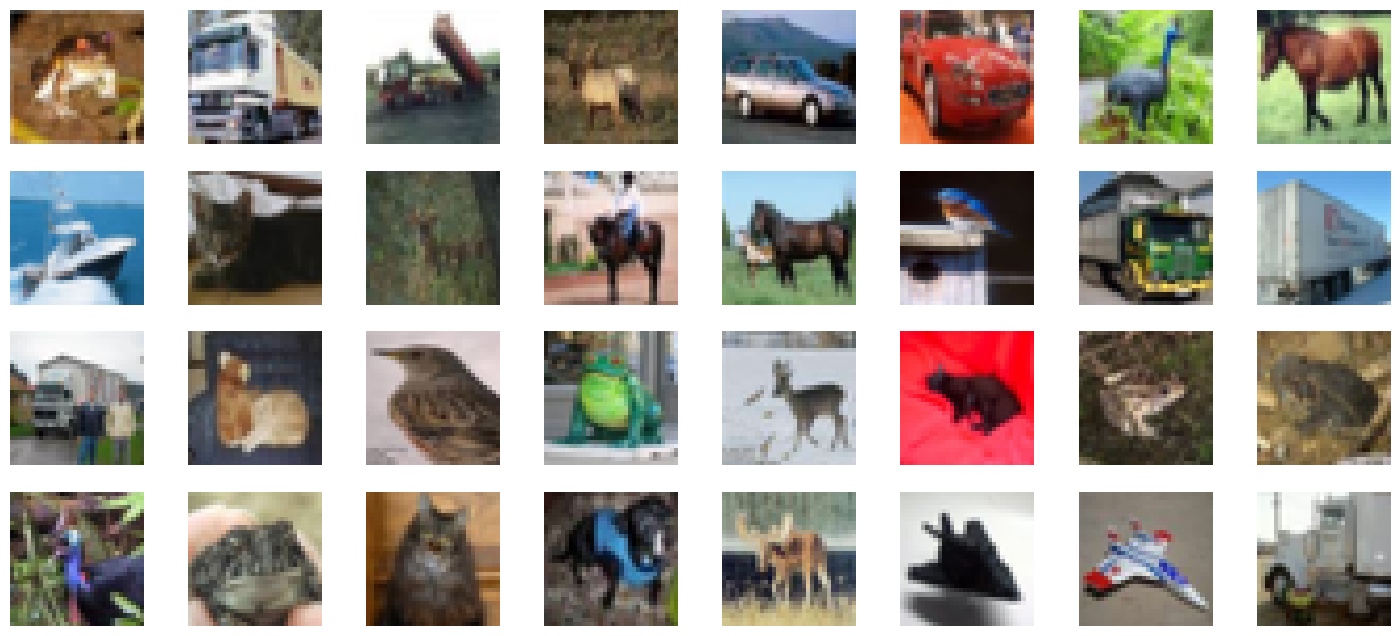

In [4]:
#displaying sample images form the dataset
plt.figure(figsize=(18, 8))

num_rows = 4
num_cols = 8

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows * num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i, :, :])
    plt.axis("off")

- Remember, images in CIFAR-10 are quite small, only 32x32 pixels, so they dont have a lot of detail

Here, we are going to normalize the image data to the range [0, 1]. This is very common when working with image data which helps the model train more efficiently. we also convert the integer labels to one-hot encoded labels

In [5]:
#normalizing images to the image [0, 1]
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32")  / 255

In [6]:
print("Original (integer) label for the first training sample: ",y_train[0])

Original (integer) label for the first training sample:  [6]


In [7]:
#convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

After conversion to categorical one-hot encoded labels:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Now we are going to apply little more structure to our training process by using the dataclass module. <br>
We are going to create simple "DatasetConfig" and "TrainingConfig" classes to organize several data and training configuration parameters.<br>
This is will allows us to create data structures for configuration parameters.

In [8]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 31
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

##Model Structure
<img src="https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-architecture.png">

In [9]:
#Model implementation
def cnn_model(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

##Classifier
<img src="https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-fully-connected-layers.png">

In [11]:
#creating the model
#summary using to display the model summary to the console
model = cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                 

In [12]:
#compiling the model
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

- RMSProp - optimizer type for gradient descent
- categorical_crossentropy - we use cross-entropy loss function which is the standard loss function for classification problems, "categorical_crossentropy" since our labels are one-hot encoded
- accuracy - specifying as an additional metric to record during training

In [13]:
#Train the model
#validation_split - using the argument for automatically reserving for validation (.3 is 30%)
history = model.fit(X_train,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_split=.3,
                   )

Epoch 1/31
137/137 [==============================] - 238s 2s/step - loss: 2.1489 - accuracy: 0.2180 - val_loss: 1.8964 - val_accuracy: 0.3332
Epoch 2/31
137/137 [==============================] - 236s 2s/step - loss: 1.7291 - accuracy: 0.3708 - val_loss: 1.5050 - val_accuracy: 0.4476
Epoch 3/31
137/137 [==============================] - 235s 2s/step - loss: 1.4945 - accuracy: 0.4587 - val_loss: 1.3664 - val_accuracy: 0.4969
Epoch 4/31
137/137 [==============================] - 233s 2s/step - loss: 1.3265 - accuracy: 0.5264 - val_loss: 1.2317 - val_accuracy: 0.5616
Epoch 5/31
137/137 [==============================] - 234s 2s/step - loss: 1.1812 - accuracy: 0.5793 - val_loss: 1.1270 - val_accuracy: 0.6025
Epoch 6/31
137/137 [==============================] - 235s 2s/step - loss: 1.0459 - accuracy: 0.6286 - val_loss: 1.0385 - val_accuracy: 0.6350
Epoch 7/31
137/137 [==============================] - 215s 2s/step - loss: 0.9281 - accuracy: 0.6709 - val_loss: 0.9600 - val_accuracy: 0.6672

In [14]:
#retrieving the training results
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

In [16]:
#function for ploting the results
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

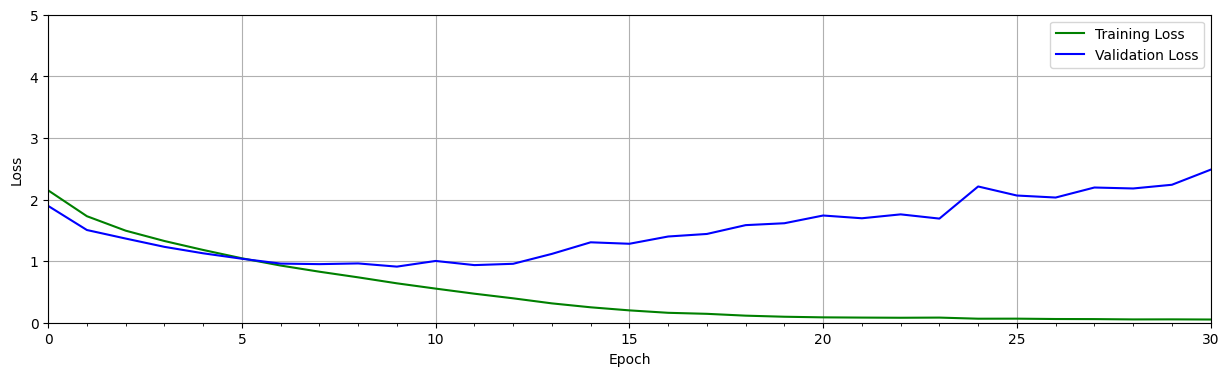

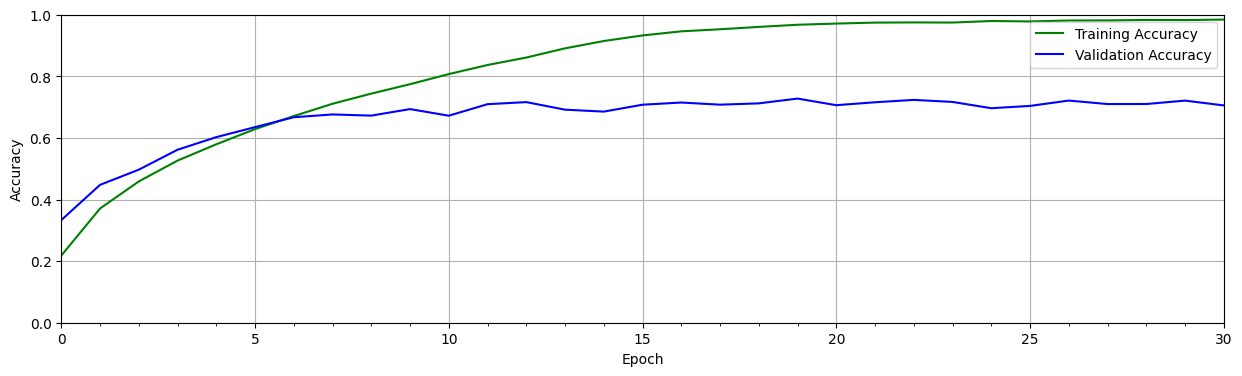

In [17]:
#plot the training results
plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

The results from our baseline model reveal that the model is overfitting. Notice that the validation loss increases after about ten epochs of training while the training loss continues to decline. This means that the network learns how to model the training data well but does not generalize to unseen test data well. The accuracy plot shows a similar trend where the validation accuracy levels off after about ten epochs while the training accuracy continues to approach 100% as training progresses. This is a common problem when training neural networks and can occur for a number of reasons. One reason is that the model can fit the nuances of the training dataset, especially when the training dataset is small.

##Adding <code>Dropout</code> to the model
Dropout is implemented in keras as a special layer type that randomly drops a percentage ofneurons during the training process.
<img src="https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-dropout-example.png">
<img src="https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-dropout-architecture.png">

In [18]:
#defining model with dropout
def cnn_model_dropout(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [19]:
#creating model with dropout
model_dropout = cnn_model_dropout()
model_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [20]:
#compiling the model with dropout
model_dropout.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [21]:
#training the model with dropout
history = model_dropout.fit(X_train,
                            y_train,
                            batch_size=TrainingConfig.BATCH_SIZE,
                            epochs=TrainingConfig.EPOCHS,
                            verbose=1,
                            validation_split=.3,
                           )

Epoch 1/31
137/137 [==============================] - 222s 2s/step - loss: 2.1021 - accuracy: 0.2275 - val_loss: 1.8408 - val_accuracy: 0.3429
Epoch 2/31
137/137 [==============================] - 236s 2s/step - loss: 1.7934 - accuracy: 0.3485 - val_loss: 1.5636 - val_accuracy: 0.4276
Epoch 3/31
137/137 [==============================] - 236s 2s/step - loss: 1.6007 - accuracy: 0.4178 - val_loss: 1.4388 - val_accuracy: 0.4708
Epoch 4/31
137/137 [==============================] - 234s 2s/step - loss: 1.4769 - accuracy: 0.4642 - val_loss: 1.4508 - val_accuracy: 0.4770
Epoch 5/31
137/137 [==============================] - 236s 2s/step - loss: 1.3720 - accuracy: 0.5061 - val_loss: 1.2846 - val_accuracy: 0.5331
Epoch 6/31
137/137 [==============================] - 237s 2s/step - loss: 1.2627 - accuracy: 0.5483 - val_loss: 1.2999 - val_accuracy: 0.5317
Epoch 7/31
137/137 [==============================] - 218s 2s/step - loss: 1.1811 - accuracy: 0.5765 - val_loss: 1.0982 - val_accuracy: 0.6077

In [22]:
#retrieving the training results
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

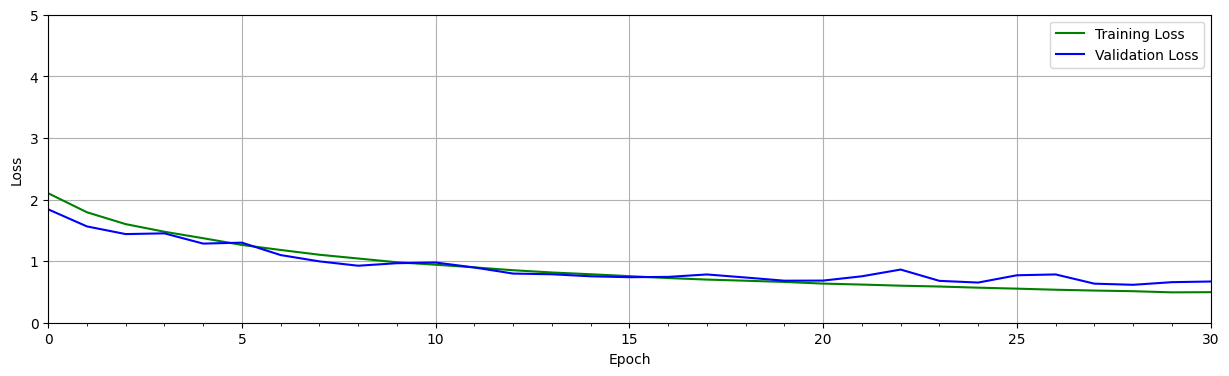

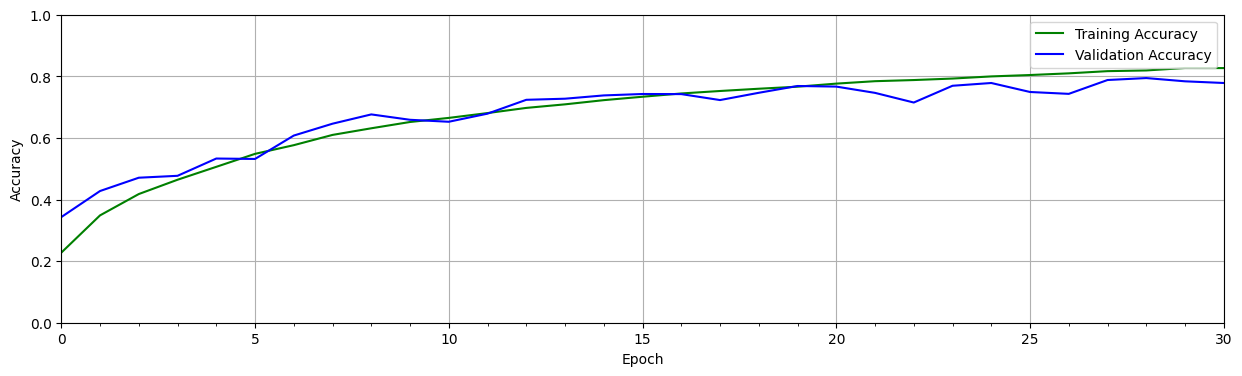

In [23]:
#plotting the result
plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

##Comparing loss with and without dropout
- Thr training curves very closely to the validation curves.
- and also notice that we achieve a higher validation accuracy than the baseline model that didnt contain dropout
<img src="https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-training-plot-comparison.png">

In [24]:
#saving model for this we are going to use save() function
model_dropout.save("model_dropout")

In [25]:
#now going the load the saved model
from tensorflow.keras import models
reloaded_model_dropout = models.load_model("model_dropout")

we will evaluate the model using <code>evaluate()</code> function. this function returns the value of loss and its accuracy of the test dataset.

In [26]:
#evaluating the model
test_loss, test_acc = reloaded_model_dropout.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 [==============================] - 17s 54ms/step - loss: 0.6903 - accuracy: 0.7685
Test accuracy: 76.850


In [27]:
#making predictions on sample test images
def evaluate_model(dataset, model):
    class_names = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    num_rows = 3
    num_cols = 6

    # Retrieve a number of images from the dataset.
    data_batch = dataset[0 : num_rows * num_cols]

    # Get predictions from model.
    predictions = model.predict(data_batch)

    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])

        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_test[idx])

        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={"fontsize": 13})

        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")

        acc = num_matches / (idx + 1)
    print("Prediction accuracy: ", int(100 * acc) / 100)

    return

1/1 [==============================] - 0s 179ms/step
Prediction accuracy:  0.88


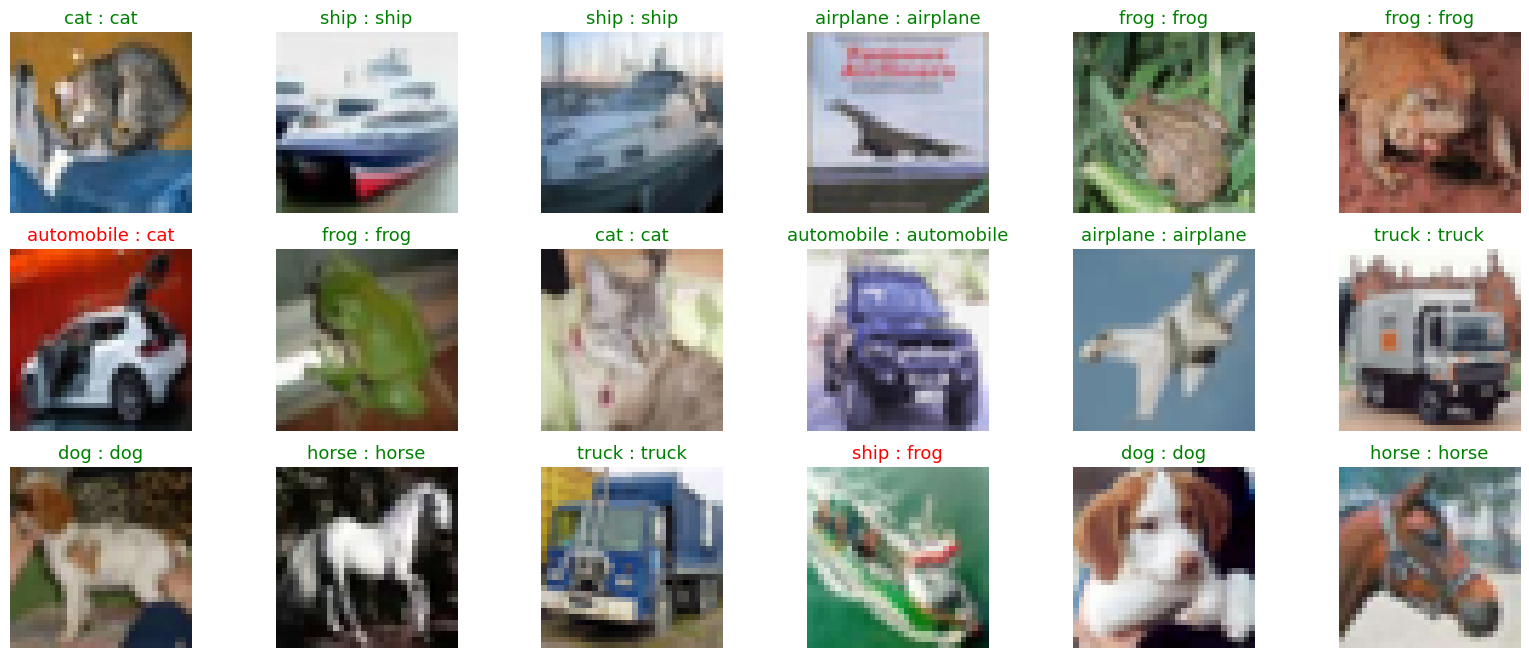

In [28]:
evaluate_model(X_test, reloaded_model_dropout)